In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy import stats

### Чтение и преобразование датасета

In [2]:
df = pd.read_csv('new_dataframe.csv')

In [3]:
df.shape

(101500, 15)

In [4]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [5]:
df.head()

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low


In [6]:
# Поля датасета:
# ● User_id - id пользователя
# ● Hour - час старта сессии
# ● App_opened - приложение открыто
# ● Price_seen - пользователь ввел данные маршрута и показана цена
# ● Order_made - пользователь кликнул по кнопке заказа
# ● Surge - в этот период был включен surge (надбавка к стоимости поездки в период повышенного спроса)
# ● Ride_completed - поездка успешно завершена
# ● User_cancelled - пользователь отменил поездку
# ● Age - возраст пользователя
# ● City_center_order - заказ был сделан из центра города
# ● Distance - дистанция в км
# ● Rfm - rfm-сегмент пользователя

In [7]:
df.describe()

,user_id,hour,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age
count,101500.000000,101500.000000,101500.0,101500.000000,101500.000000,101500.000000,101500.000000,101500.000000,91431.000000,101500.000000
mean,549874.802207,11.481429,1.0,0.900798,0.731389,0.620365,0.111025,0.571675,5.371152,25.906384
std,258600.104176,6.917522,0.0,0.298934,0.443239,0.485299,0.314164,0.494838,4.118531,7.838328
min,100093.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.010946,18.000000
25%,328223.000000,5.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,2.438335,20.000000
50%,548827.000000,11.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,4.279565,24.000000
75%,773051.000000,17.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.000000,7.129814,29.000000
max,999978.000000,23.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,40.268966,69.000000


In [8]:
# Оцифруем категорийные переменные os, order_class, rfm 
df = df.replace({'os' : { 'Android' : 0, 'iOS' : 1}, 'order_class' : {'economy' : 0, 'comfort' : 1, 'business' : 2}, \
                'surge' : {'surge' : 1, 'no surge' : 0}, 'rfm' : {'low' : 0, 'medium' : 1, 'high' : 2}})
df.head()

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,867689,12,1,2,0.0,1,1,1,1,0,0,7.982135,20,0
1,752172,5,0,0,0.0,1,1,1,1,0,1,2.908468,27,2
2,486559,15,0,1,0.0,1,1,1,1,0,0,7.224614,21,2
3,304024,0,0,0,0.0,1,1,1,1,0,1,1.874349,52,0
4,139420,0,0,2,0.0,1,1,1,1,0,0,10.704778,19,0


### Проверка особенностей

In [9]:
# Особенность 1. В период Surge видим более низкую price-to-order конверсию
tf = df[['surge', 'price_seen', 'order_made']].groupby('surge').sum()
tf['conv'] = round(tf['order_made'] / tf['price_seen'], 2)
tf.head()

,price_seen,order_made,conv
surge,,,
0.0,59788,51363,0.86
1.0,31643,22873,0.72


Действительно, в период высокого спроса конверсия из запроса цены в заказ существенно ниже

In [10]:
# Особенность 2. Для устройств Android наблюдаем более высокие юзерские отмены
tf = df[['os', 'order_made', 'user_cancelled']].groupby('os').sum()
tf['conv'] = round(tf['user_cancelled'] / tf['order_made'], 2)
tf.head()


,order_made,user_cancelled,conv
os,,,
0,38801,7353,0.19
1,35435,3916,0.11


Действительно, для устройств Android наблюдаем более частые отмены заказов

In [11]:
# Особенность 3. Если Заказ из центра, то видим более низкие юзерские отмены
tf = df[['city_center_order', 'order_made', 'user_cancelled']].groupby('city_center_order').sum()
tf['conv'] = round(tf['user_cancelled'] / tf['order_made'], 2)
tf.head()

,order_made,user_cancelled,conv
city_center_order,,,
0,29745,5632,0.19
1,44491,5637,0.13


Действительно, для заказов из центра города наблюдаем более редкие отмены заказов

In [12]:
# Особенность 4. Если Comfort & Business классы, то более низкие юзерские отмены, более длинные поездки
tf = df[['order_class', 'order_made', 'user_cancelled']].groupby('order_class').sum()
tf['conv'] = round(tf['user_cancelled'] / tf['order_made'], 2)
tf.head()

,order_made,user_cancelled,conv
order_class,,,
0,34872,6209,0.18
1,30651,4049,0.13
2,8713,1011,0.12


In [13]:
df[['order_class', 'distance']].groupby('order_class').mean()

,distance
order_class,
0,3.997445
1,5.025267
2,12.013842


Действительно, чем выше класс такси, тем более редки отмены и тем больше расстояние поездок

### Формулировка гипотез

Внимание - допущение! Обе гипотезы предполагают, что у сервиса такси есть бонусная программа, позволяющая накапливать и тратить бонусы. 

**Гипотеза 1. В период Surge видим более низкую price-to-order конверсию**  
Формулировка гипотезы: если мы будем предлагать начисление двойных бонусных баллов при заказе такси в периоды высокого спроса ("сурж"), то конверсия в заказ повысится на 5 п.п.  
Тестируемое изменение: как начисление повышенных бонусов повлияет на склонность клиента сделать заказ, несмотря на наличие надбавки к цене заказа.  
Бизнес-цель: увеличение конверсии  
Генеральная совокупность: все клиенты сервиса, делающие заказ в период повышенного спроса  
Первичная метрика: конверсия из запроса цены в заказ  
Вторичная метрика: доля отмен

**Гипотеза 3. Если Заказ из центра, то видим более низкие юзерские отмены**  
Формулировка гипотезы: если мы будем начислять 100 бонусных баллов при поездках не из центра города, то доля отмененных заказов снизится на 3 п.п.  
Тестируемое изменение: как начисление бонусов повлияет на склонность клиента успешно завершить поездку не из центра города. Бизнес-цель: увеличение конверсии  
Генеральная совокупность: все клиенты сервиса, делающие заказ не из центра города  
Первичная метрика: конверсия из заказа в успешно завершенную поездку  
Вторичная метрика: средний доход на одну поездку не из центра города

### Формирование групп для тестирования

#### Группа для гипотезы 1. В период Surge видим более низкую price-to-order конверсию

In [24]:
# фильтрация по целевому признаку и группировка клиентов
df1 = df[['user_id', 'price_seen', 'order_made']][df['surge'] == 1].groupby('user_id').sum()
df1['conversion'] = round(df1['order_made'] / df1['price_seen'], 3)
df1.head()

,price_seen,order_made,conversion
user_id,,,
100093,2,1,0.5
100118,1,1,1.0
100134,1,1,1.0
100166,2,2,1.0
100255,2,0,0.0


In [25]:
df1.shape

(17780, 3)

In [26]:
random.seed(42)
df1['rnd'] = df1.apply(lambda _: random.random(), axis = 1)
df1.loc[df1['rnd'] > 0.5,'test_group'] = 1
df1.loc[df1['rnd'] <= 0.5,'test_group'] = 0


In [27]:
df1.head()

,price_seen,order_made,conversion,rnd,test_group
user_id,,,,,
100093,2,1,0.5,0.639427,1.0
100118,1,1,1.0,0.025011,0.0
100134,1,1,1.0,0.275029,0.0
100166,2,2,1.0,0.223211,0.0
100255,2,0,0.0,0.736471,1.0


In [28]:
# размеры тестовой и контрольной групп
df1['test_group'].value_counts()

1.0    8939
0.0    8841
Name: test_group, dtype: int64

In [29]:
# выборочные средние тестовой и контрольной групп
df1[['conversion', 'test_group']].groupby('test_group').mean()

,conversion
test_group,
0.0,0.724177
1.0,0.722894


Разница средних конверсий тестовой и контрольной групп - в третьем знаке после запятой. Тем не менее необходимо проверить статистическую равность выборочных средних.  
Нулевая гипотеза: выборочные средние двух групп равны  
Альтернативная гипотеза: выборочные средние двух групп различаются  
Уровень значимости примем равным 5%

Так как количество значений в тестовой и контрольной группах очень велико, то на нормальность распределение случайной величины проверять нет необходимости. 

In [50]:
stats.ttest_ind(df1['conversion'][df1['test_group'] == 1], df1['conversion'][df1['test_group'] == 0])

Ttest_indResult(statistic=-0.22636846354509182, pvalue=0.8209174562557549)

In [51]:
stats.ttest_ind(df1['conversion'][df1['test_group'] == 1], df1['conversion'][df1['test_group'] == 0], equal_var = False)

Ttest_indResult(statistic=-0.22638000575758344, pvalue=0.8209084800202324)

Так как p-value выше уровня значимости (и значительно), то мы не можем отвергнуть нулевую гипотезу. Поэтому будем считать, что выборочные средние тестовой и контрольной групп одинаковы. Можно использовать полученные группы для тестирования гипотезы.

#### Группа для гипотезы 3. Если Заказ из центра, то видим более низкие юзерские отмены

Ниже - аналогичные расчеты для гипотезы 3 (без комментариев)

In [76]:
df3 = df[['user_id', 'order_made', 'user_cancelled']][df['city_center_order'] == 0].groupby('user_id').sum()
df3['conversion'] = round(df3['user_cancelled'] / df3['order_made'], 3)
df3.dropna(inplace = True) # есть пользователи, которые ни разу не делали заказ не из центра, хотя и просматривали цену
df3.head()

,order_made,user_cancelled,conversion
user_id,,,
100093,2,0,0.000
100118,5,1,0.200
100134,2,1,0.500
100166,3,1,0.333
100255,3,0,0.000


In [77]:
random.seed(42)
df3['rnd'] = df3.apply(lambda _: random.random(), axis = 1)
df3.loc[df3['rnd'] > 0.5,'test_group'] = 1
df3.loc[df3['rnd'] <= 0.5,'test_group'] = 0
df3.head()

,order_made,user_cancelled,conversion,rnd,test_group
user_id,,,,,
100093,2,0,0.000,0.639427,1.0
100118,5,1,0.200,0.025011,0.0
100134,2,1,0.500,0.275029,0.0
100166,3,1,0.333,0.223211,0.0
100255,3,0,0.000,0.736471,1.0


In [78]:
df3['test_group'].value_counts()

1.0    8671
0.0    8574
Name: test_group, dtype: int64

In [79]:
df3[['conversion', 'test_group']].groupby('test_group').mean()

,conversion
test_group,
0.0,0.191148
1.0,0.186641


In [80]:
stats.ttest_ind(df3['conversion'][df3['test_group'] == 1], df3['conversion'][df3['test_group'] == 0])

Ttest_indResult(statistic=-0.8915945933049212, pvalue=0.3726227103161035)

In [82]:
stats.ttest_ind(df3['conversion'][df3['test_group'] == 1], df3['conversion'][df3['test_group'] == 0], equal_var = False)

Ttest_indResult(statistic=-0.8915328480760496, pvalue=0.3726558245295467)

Вывод аналогичен - так как p-value выше уровня значимости, то мы не можем отвергнуть нулевую гипотезу. Поэтому будем считать, что выборочные средние тестовой и контрольной групп одинаковы. Можно использовать полученные группы для тестирования гипотезы 3.

### Разнообразные графики

<Figure size 432x288 with 0 Axes>

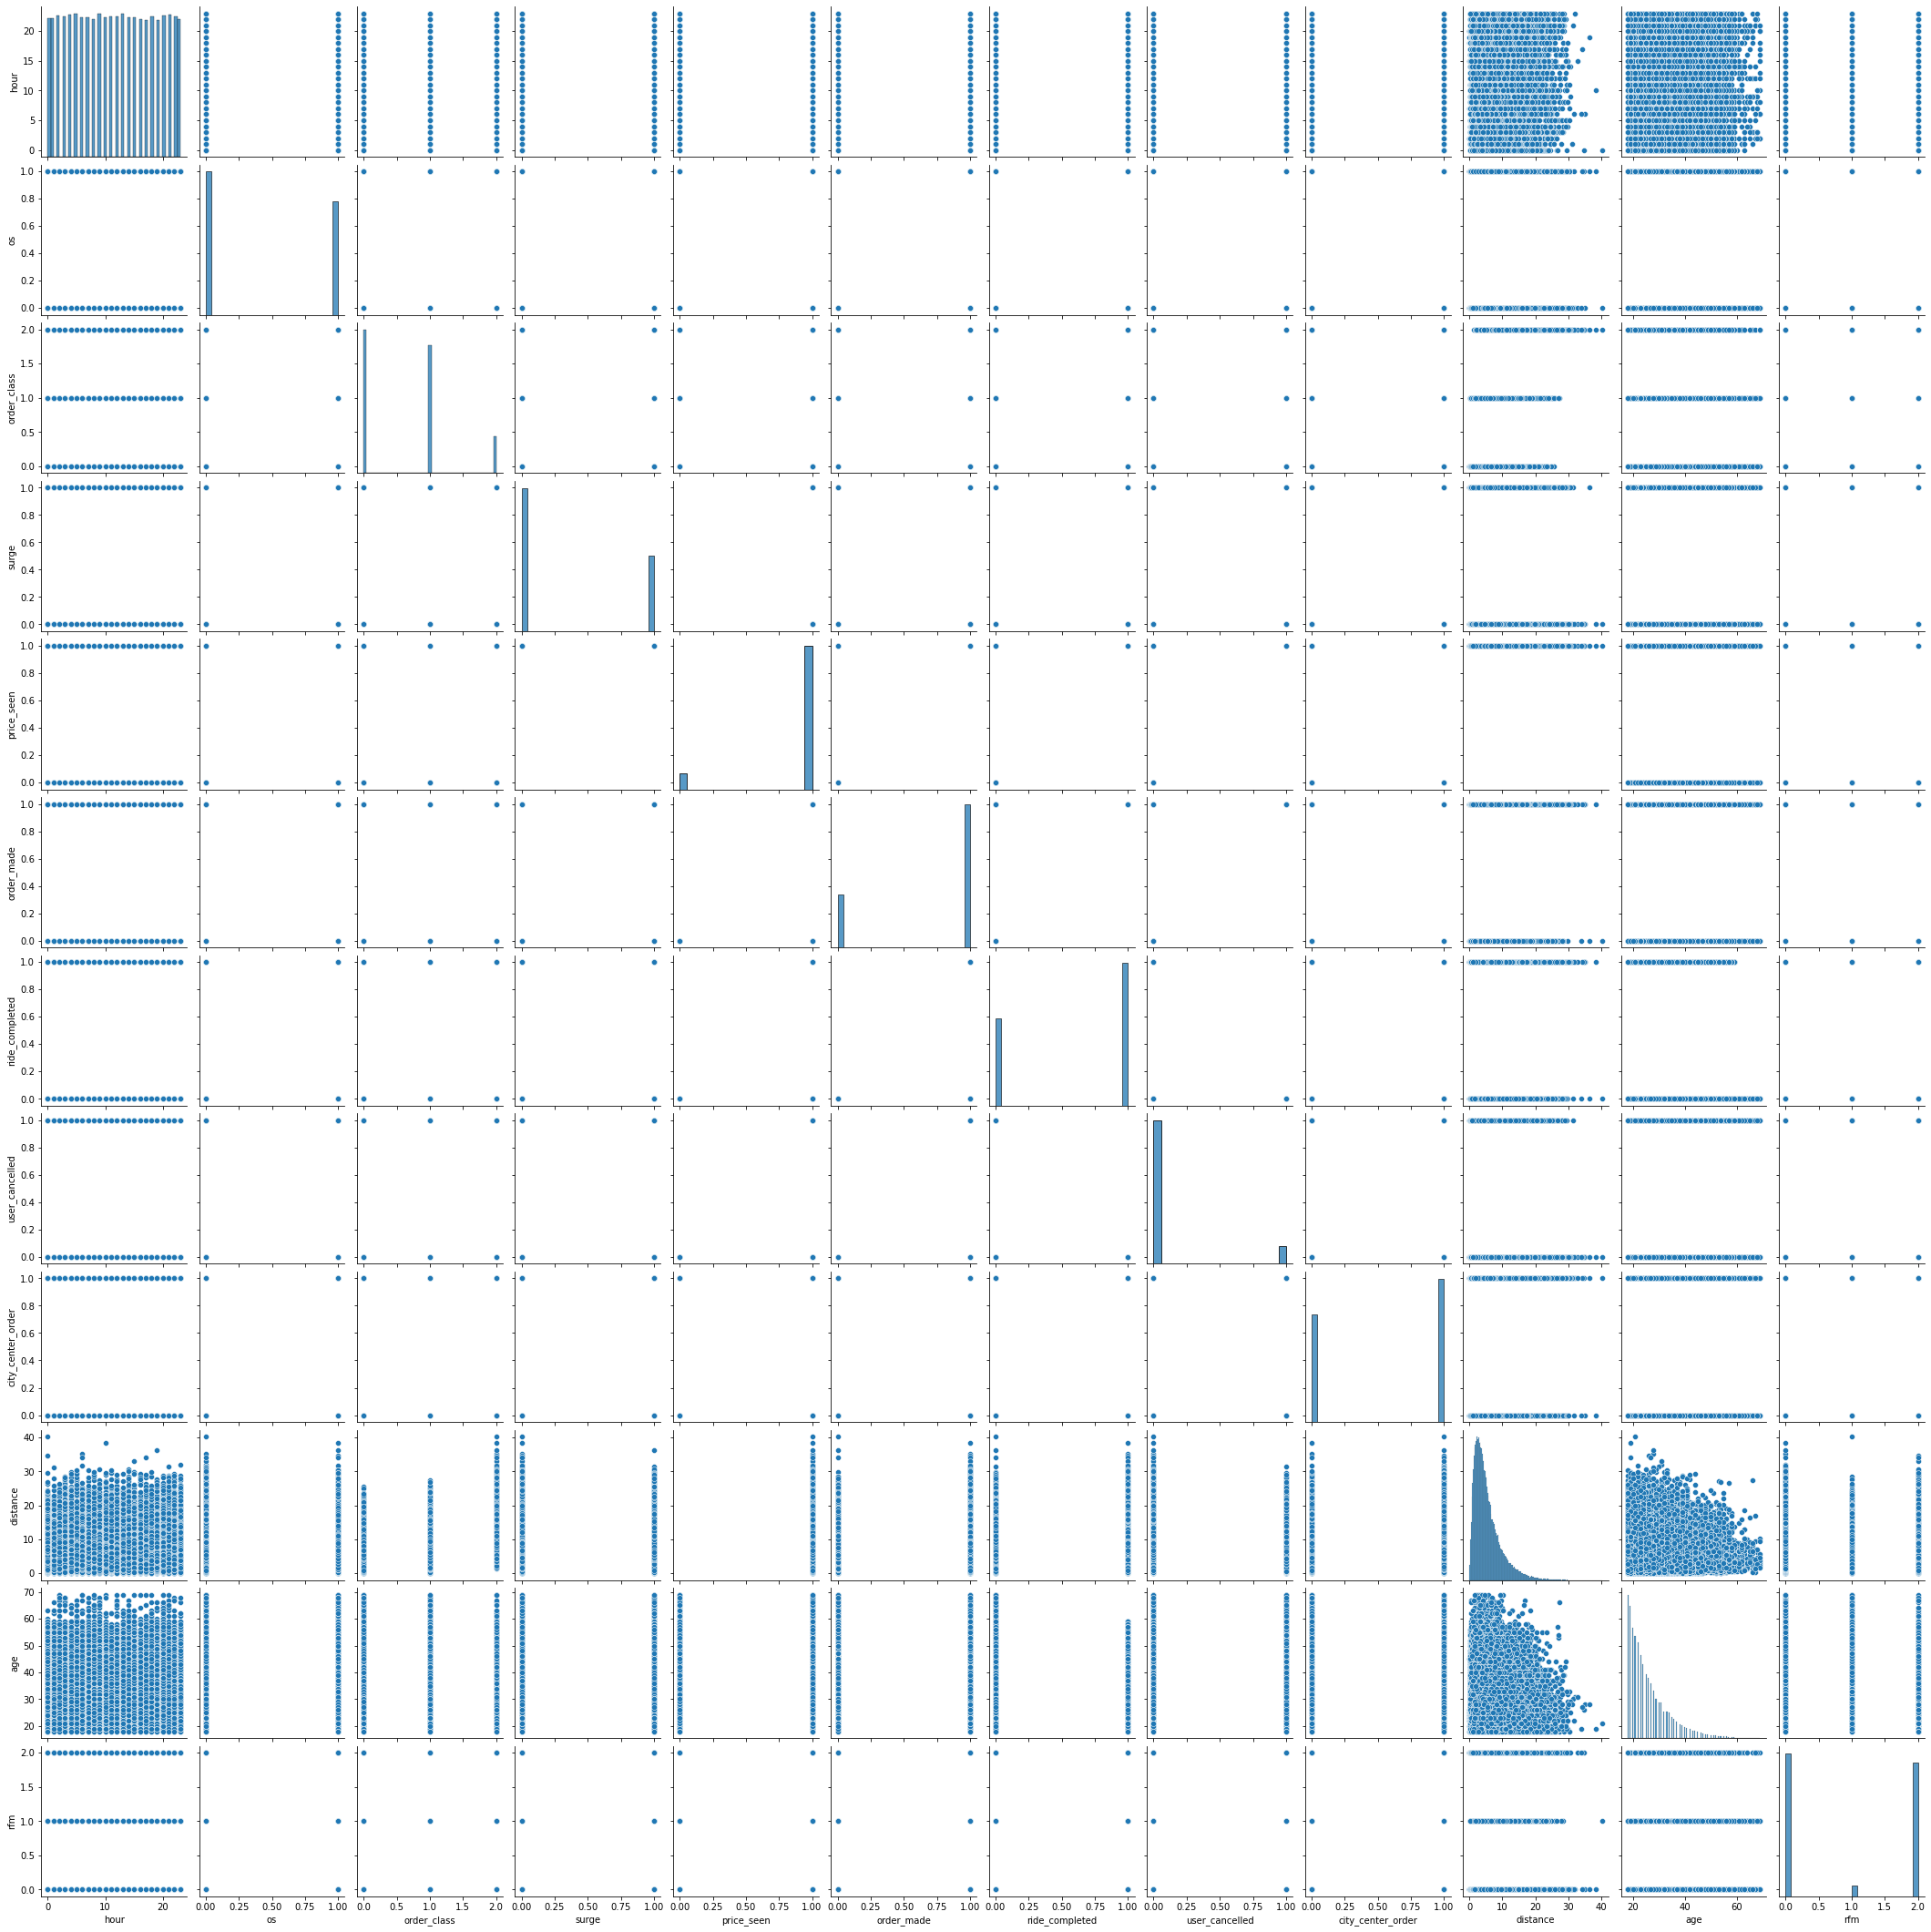

In [10]:
# Построим парные диаграммы рассеяния для всех переменных
plt.figure()
sns.pairplot(data = df[['hour', 'os', 'order_class', 'surge', 
       'price_seen', 'order_made', 'ride_completed', 'user_cancelled',
       'city_center_order', 'distance', 'age', 'rfm']], dropna = True);

In [11]:
#plt.figure(figsize = (12, 6))
#lines = df1.groupby('onlymonth')['dow'].count().plot.line()
#lines = df.groupby('month')['CustomerID'].nunique()[:-1].plot.bar(title = 'Количество уникальных покупателей', xlabel = '')
sf = df.groupby('user_id')['user_id'].count()
df1 = pd.DataFrame({'user_id':sf.index, 'num':sf.values})

In [12]:
df1.sort_values(by = ['num'], ascending = False).head()

,user_id,num
2294,185364,14
8199,405533,14
22863,948899,13
1439,153818,13
7580,382672,13


<AxesSubplot:title={'center':'Количество заказов от одного пользователя'}>

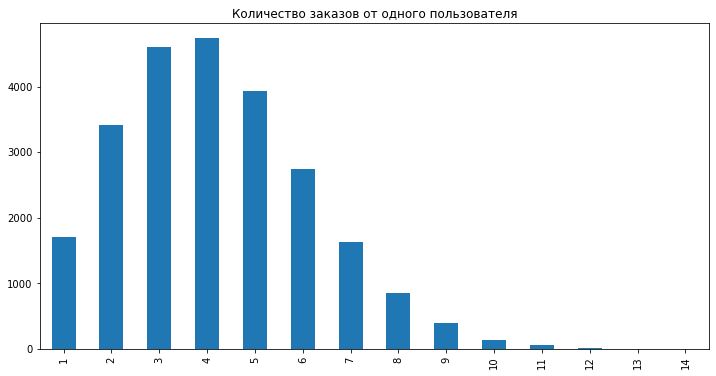

In [13]:
plt.figure(figsize = (12, 6))
df1.groupby('num')['num'].count().plot.bar(title = 'Количество заказов от одного пользователя', xlabel = '')


In [14]:
df = pd.merge(df, df1, on = "user_id")

In [15]:
df.head()

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm,num
0,867689,12,1,2,0.0,1,1,1,1,0,0,7.982135,20,0,3
1,867689,9,0,0,1.0,1,1,1,1,0,0,5.444248,20,0,3
2,867689,6,1,1,0.0,1,1,1,1,0,0,18.213431,20,0,3
3,752172,5,0,0,0.0,1,1,1,1,0,1,2.908468,27,2,2
4,752172,8,0,1,1.0,1,1,1,1,0,0,5.520360,27,2,2


In [44]:
# в какой час какие классы заказывают 
tf = df[df['order_made'] != 100][['os', 'user_cancelled', 'user_id']].groupby(['os', 'user_cancelled']).count()

In [45]:
tf.to_excel('ab12.xlsx')